<a href="https://colab.research.google.com/github/nebuus/fun/blob/main/Anete_cat_final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation  # this is needed for the animation API
import matplotlib.image as mpimg # for grayscale input image
from matplotlib.colors import Normalize   # this is needed to rescale the color during the simulation

In [ ]:
#@title Def functions
def get_initial_configuration(N, random_influence=0.2):
    """
    N is the side length of the (N x N)-sized grid.
    `random_influence` describes how much noise is added.
    """

    # We start with a configuration where on every grid cell
    # there's a lot of chemical A, so the concentration is high
    AA = (1-random_influence) * np.ones((N,N)) + random_influence * np.random.random((N,N))

    # Let's assume there's only a bit of B everywhere
    BB = random_influence * np.random.random((N,N))

    return AA, BB

def draw(A,B):
    """draw the concentrations"""
    %matplotlib inline
    plt.clf()
    fig, ax = plt.subplots(1,2,figsize=(5.65,4))
    ax[0].imshow(A, cmap='Greys')
    ax[1].imshow(B, cmap='Greys')
    ax[0].set_title('A')
    ax[1].set_title('B')
    ax[0].axis('off')
    ax[1].axis('off')

    plt.show()

def discrete_laplacian1(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0, 1), (0, 1))  # right neighbor
    L += np.roll(M, (0, -1), (0, 1))  # left neighbor
    L += np.roll(M, (-1, 0), (0, 1))  # top neighbor
    L += np.roll(M, (1, 0), (0, 1))  # bottom neighbor

    return L

def gray_scott_update1(A, B, DA, DB, f, k, delta_t):
    """
    Updates a concentration configuration according to a Gray-Scott model
    with diffusion coefficients DA and DB, as well as feed rate f and
    kill rate k.
    """
    #A, B = torch.tensor(A.detach().cpu().numpy()), torch.tensor(B.detach().cpu().numpy())

    # Let's get the discrete Laplacians first
    LA = discrete_laplacian1(A)
    LB = discrete_laplacian1(B)

    # Now apply the update formula
    diff_A = (DA*LA - A*B**2 + f*(1-A)) * delta_t
    diff_B = (DB*LB + A*B**2 - (k+f)*B) * delta_t

    A_res = A + diff_A
    B_res = B + diff_B

    return A_res, B_res

<Figure size 640x480 with 0 Axes>

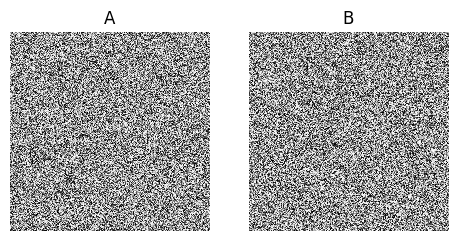

In [ ]:
#@title Get initial configuration {vertical-output: true}
%matplotlib inline
A_init, B_init = get_initial_configuration(200)
draw(A_init, B_init)

<Figure size 640x480 with 0 Axes>

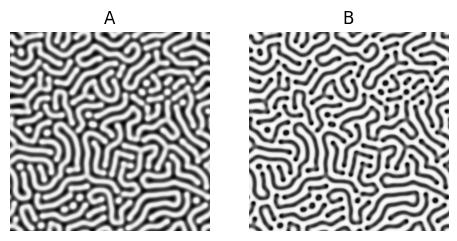

In [ ]:
#@title Get the synthetic target configuration {vertical-output: true}
# update in time
delta_t = 1.0

# simulation steps
N_simulation_steps = 2000

A_res, B_res = A_init, B_init

DA, DB, f, k = 0.14, 0.06, 0.040, 0.062 # bacteria
for t in range(N_simulation_steps):
    A_res, B_res = gray_scott_update1(A_res, B_res, DA, DB, f, k, delta_t)

A_target, B_target = A_res, B_res

draw(A_target,B_target)

<Figure size 640x480 with 0 Axes>

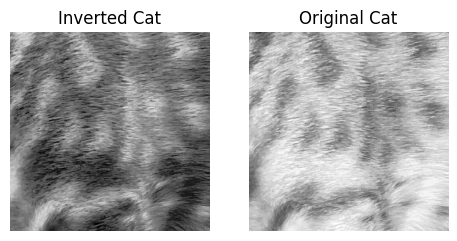

In [ ]:
#@title Get the target configuration from image {vertical-output: true}
# importing pic, turning it grayscale and plotting it
from skimage import io
from skimage.transform import resize
img = resize(io.imread('/content/cut1.jpg', as_gray=True), (200, 200))
inverted_img = 1 - img
plt.clf()
fig, ax = plt.subplots(1,2,figsize=(5.65,4))
ax[0].imshow(img, cmap='Greys')
ax[0].set_title('Inverted Cat')
ax[0].axis('off')
ax[1].imshow(inverted_img, cmap='Greys')
ax[1].set_title('Original Cat')
ax[1].axis('off')
plt.show()

# reinforcement NN part

In [ ]:
##
def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4 * M
    L += torch.roll(M, (0, 1), (0, 1))  # right neighbor
    L += torch.roll(M, (0, -1), (0, 1))  # left neighbor
    L += torch.roll(M, (-1, 0), (0, 1))  # top neighbor
    L += torch.roll(M, (1, 0), (0, 1))  # bottom neighbor

    return L

def gray_scott_update(A, B, DA, DB, f, k, delta_t, N_simulation_steps):
    for t in range(N_simulation_steps):
        # discrete Laplacians
        LA = discrete_laplacian(A.detach())
        LB = discrete_laplacian(B.detach())

        # Update in time
        diff_A = (DA * LA - A * B**2 + f * (1 - A)) * delta_t
        diff_B = (DB * LB + A * B**2 - (k + f) * B) * delta_t

        A = A + diff_A
        B = B + diff_B

    A_updated, B_updated = A, B

    return A_updated, B_updated

In [ ]:
# Define a neural network to learn f and k
class GrayScottModel(nn.Module):
    def __init__(self):
        super(GrayScottModel, self).__init__()
        self.f = nn.Parameter(torch.tensor(0.03,requires_grad=True))
        self.k = nn.Parameter(torch.tensor(0.06, requires_grad=True))

    def forward(self, A, B, DA, DB, delta_t, N_simulation_steps):
        f_clamped = torch.sigmoid(self.f)
        k_clamped = torch.sigmoid(self.k)
        A_updated, B_updated = gray_scott_update(A, B, DA, DB, f_clamped, k_clamped, delta_t, N_simulation_steps)
        return A_updated, B_updated

In [ ]:
A_updated = torch.tensor(A_init, dtype=torch.float32, requires_grad=True)
B_updated = torch.tensor(B_init, dtype=torch.float32, requires_grad=True)

A_target_tensor = torch.tensor(A_target, dtype=torch.float32, requires_grad=True)
B_target_tensor = torch.tensor(B_target, dtype=torch.float32, requires_grad=True)

In [ ]:
# Instantiate the model, set up optimizer, and define the loss function
model = GrayScottModel()
optimizer = optim.Adam(model.parameters(), lr=0.02)
criterion = nn.MSELoss()

# Training loop
num_epochs = 300
delta_t = 1.0
DA = 0.14
DB = 0.06
N_simulation_steps = 20
#learning_rate = 0.001

In [ ]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    A_updated, B_updated = model(A_updated, B_updated, DA, DB, delta_t, N_simulation_steps)

    A_tensor, B_tensor = A_updated, B_updated

    # Compute loss
    loss_A = criterion(A_tensor, A_target_tensor)
    loss_B = criterion(B_tensor, B_target_tensor)

    # Backward pass and optimization
    loss_A.backward(retain_graph=True)
    loss_B.backward(retain_graph=True)

    optimizer.step()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    f_clamped = torch.clamp(torch.sigmoid(model.f), 0, 1)
    k_clamped = torch.sigmoid(model.k)

    loss = loss_A + loss_B

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Get the optimized parameters
f_optimized, k_optimized = model.f.item(), model.k.item()
print(f'Optimized Parameters: f={f_clamped}, k={k_clamped}')

Epoch [100/6000], Loss: 0.0429
Epoch [200/6000], Loss: 0.0429


KeyboardInterrupt: ignored

In [ ]:
f_optimized, k_optimized = model.f.item(), model.k.item()
print(f'Optimized Parameters: f={f_clamped}, k={k_clamped}')

Optimized Parameters: f=0.4936599135398865, k=0.5147358179092407


# Drawing the NN output

In [ ]:
# {vertical-output: true}
delta_t = 200.0

# simulation steps
N_simulation_steps = 1

DA, DB = 0.14, 0.06
f = f_clamped
k = k_clamped
for t in range(N_simulation_steps):
    A_check, B_check = gray_scott_update1(A_init, B_init, DA, DB, f, k, delta_t)

draw(A_check,B_check)

NameError: ignored

<Figure size 640x480 with 0 Axes>

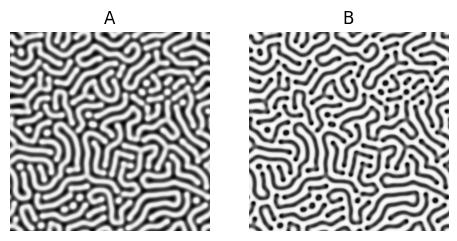

In [ ]:
# {vertical-output: true}
draw(A_target,B_target)

#Creating a train set

In [ ]:
# Creating training data by generating a bunch of 200x200 images
delta_t = 1.0
N_simulation_steps = 2000
f_values = np.arange(0.002, 0.120, 0.001)
k_values = np.arange(0.014, 0.035, 0.001)
A_res, B_res = A_init, B_init
DA, DB = 0.14, 0.06
training = []

for f in f_values:
  for k in k_values:
    A_res, B_res = A_init, B_init

    for t in range(N_simulation_steps):
        A_res, B_res = gray_scott_update1(A_res, B_res, DA, DB, f, k, delta_t)

    training.append({
          'f': f.item(),
          'k': k,
          'A_target': A_res,
          'B_target': B_res
      })

np.save('training.npy', np.array(training, dtype=object), allow_pickle=True)

In [ ]:
len(training)

2596

<Figure size 640x480 with 0 Axes>

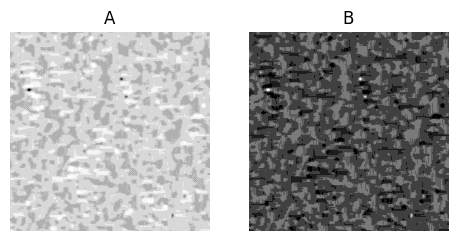

In [ ]:
# Checking if it did it sort of right
aaa = training[1000]['A_target']
bbb = training[1000]['B_target']
draw(aaa, bbb)

#VGG transfer learning

In [ ]:
# Splitting the data in 2 - inputs and targets
# annotations = [{'f': row['f'], 'k': row['k']} for row in training]
# imgs = [{'A_target': line['A_target'], 'B_target': line['B_target']} for line in training]

annotations = []
imgs = []
for trainingData in training:
  annotations.append({'f': trainingData['f'], 'k': trainingData['k']})
  imgs.append({'A_target': trainingData['A_target'], 'B_target': trainingData['B_target']})

In [ ]:
#torch.multiprocessing.set_start_method('spawn')
device = ("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(66)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.fromarray((self.data[idx]['A_target'] * 255).astype(np.uint8))  # Assuming image is stored in 'image' key
        label = torch.tensor([self.data[idx]['k'], self.data[idx]['f']], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label

# Load your dataset and split into training and testing sets
# Make sure to replace this with your actual data loading logic
# Assume your data is a list of dictionaries with 'image', 'k', and 'f' keys
data = training  # Replace with your data loading code

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])

# Define transformations for the images (adjust as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create instances of the custom dataset
train_dataset = CustomDataset(train_data, transform=transform)
test_dataset = CustomDataset(test_data, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the VGG model with modified output for 2 float values
class CustomVGG(nn.Module):
    def __init__(self):
        super(CustomVGG, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        # Modify the first layer to accept 1 channel instead of 3
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.vgg.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 2)  # Output layer with 2 neurons for k and f
        )

    def forward(self, x):
        return self.vgg(x)

# Instantiate the model
model = CustomVGG()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print training loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on the test set
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss = criterion(outputs, labels)

    print(f'Test Loss: {test_loss.item():.4f}')


Epoch [1/10], Loss: 0.0009
Epoch [2/10], Loss: 0.0006
Epoch [3/10], Loss: 0.0006
Epoch [4/10], Loss: 0.0003


In [ ]:
torch.save(model.state_dict(), '/content/cat_model.pth')

# Load the model later
#model = CustomVGG()
#model.load_state_dict(torch.load('path/to/save/model.pth'))
#model.eval()

NameError: ignored

In [ ]:
git init
git add /content/cat_model.pth
git commit -m "Add trained model weights"
git remote add origin https://github.com/nebuus/fun/tree/extra.git

# Push the changes to GitHub
git push -u origin master

In [ ]:
sample_input = torch.randn((1, 1, 200, 200))
output_size = model(sample_input).size()

print("Output size:", output_size)

Output size: torch.Size([1, 1000])


In [ ]:
check_accuracy(test_loader, model)

NameError: ignored

In [ ]:
from sklearn.metrics import precision_score, f1_score, recall_score
model.to('cpu')
y_pred, y_true = get_predictions(test_loader)

f1 = f1_score(y_true, y_pred, average='macro')
recall_score = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')

print(f'Performance scores: precision={precision}, recall={recall_score}, f1 = {f1}')

ValueError: ignored

# CA approach

In [1]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
from scipy import ndimage

from tqdm import tnrange

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_tmp.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_tmp.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.fade_len = int(kw.get('fade_len', 1.0)*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.fade_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.fade_len:
      super().add(self._outro.pop(0))

  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


  from scipy.ndimage.filters import gaussian_filter



Parameter count: 8320
Seed state examples:


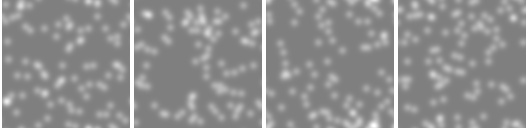

In [4]:
from scipy.ndimage.filters import gaussian_filter
from tensorflow.keras.layers import Conv2D

# Jāpamēģina mazāk kanāli
CHN = 32

def seed_f(n, sz=96, spot_prob=0.005, spread=3.0):
  '''Create init with scattered blobs'''
  x = tf.floor(tf.random.uniform([n, sz, sz, 1])+spot_prob)
  x = gaussian_filter(x, [0.0, spread, spread, 0.0], mode='wrap')
  x = x*spread**2
  x = tf.repeat(x, 3, -1)
  x = tf.pad(x, [(0, 0), (0, 0), (0, 0), (0, CHN-x.shape[-1])])
  return x.numpy()

def pad_repeat(x, pad=1):
  x = tf.concat([x[:, -pad:], x, x[:, :pad]], 1)
  x = tf.concat([x[:, :, -pad:], x, x[:, :, :pad]], 2)
  return x

def to_rgb(x):
  return x[...,:3]+0.5

@tf.function
def laplacian(x):
  lap = np.float32([[ 1, 2, 1], [2, 4-16, 2], [1, 2, 1]]) / 16.0
  kernel = tf.repeat(lap[:,:,None,None], x.shape[-1], 2)
  x = pad_repeat(x, 1)
  y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'VALID')
  return y


class CA(tf.Module):
  def __init__(self):
    self.w1 = Conv2D(128, 1)
    self.w2 = Conv2D(CHN, 1, use_bias=False, kernel_initializer=tf.zeros)
    self.diff_coef = tf.repeat([0.125, 0.25, 0.5, 1.0], CHN//4)
    self(seed_f(1))

  def get_giff_coef(self):
    return self.diff_coef

  @tf.function
  def __call__(self, x, r=1.0, d=1.0):
    diff = laplacian(x)*self.get_giff_coef()
    y = self.w1(x)
    y = y*tf.nn.sigmoid(y*5.0)
    react = self.w2(y)
    x = x + diff*d + react*r
    return x

ca = CA()
param_n = np.sum([np.prod(v.shape) for v in ca.trainable_variables])
print('Parameter count:', param_n)

print('Seed state examples:')
img = to_rgb(seed_f(4, 128))
img = np.pad(img, [(0, 0), (0, 0), (2, 2), (0, 0)], constant_values=1.0)
imshow(np.hstack(img))

In [5]:
#VGG16 down
STYLE_LAYERS = ['block%d_conv1'%i for i in range(1, 6)]
CONTENT_LAYER = 'block4_conv2'

class StyleModel:
  def __init__(self):
    vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
    vgg.trainable = False
    layers = STYLE_LAYERS + [CONTENT_LAYER]
    layers = {name:vgg.get_layer(name).output for name in layers}
    self.model = tf.keras.Model([vgg.input], layers)

  #@tf.function(experimental_relax_shapes=True)
  def run_model(self, img):
    img = img[..., ::-1]*255.0 - np.float32([103.939, 116.779, 123.68])
    layers = self.model(img)
    style = [layers[name] for name in STYLE_LAYERS]
    return style, layers[CONTENT_LAYER]

  def calc_style_content(self, img):
    style_layers, content = self.run_model(img)
    style = [gram_style(a) for a in style_layers]
    return style, content

def gram_style(a):
  n, h, w, ch = tf.unstack(tf.shape(a))
  a = tf.sqrt(a+1.0)-1.0
  gram = tf.einsum('bhwc, bhwd -> bcd', a, a)
  return gram / tf.cast(h*w, tf.float32)

@tf.function
def style_loss(a, b): # reduce_mean
  return tf.add_n([tf.reduce_mean(tf.square(x-y), [-2, -1]) for x, y in zip(a, b)])


style_model = StyleModel()


58889256/58889256 [==============================] - 0s 0us/step


In [6]:
# Inception model down
inception_pb = 'gs://modelzoo/vision/other_models/InceptionV1.pb'

class Inception:
  def __init__(self):
    with tf.io.gfile.GFile(inception_pb, 'rb') as f:
      self.graph_def = tf.compat.v1.GraphDef.FromString(f.read())
    avgpool0_idx = [n.name for n in self.graph_def.node].index('avgpool0')
    del self.graph_def.node[avgpool0_idx:]
    del self.graph_def.node[0]  # placeholder
    # use pre_relu layers for Concat nodes
    self.outputs = []
    for node in self.graph_def.node:
      if 'Concat' in node.op:
        self.outputs.append(node.name+':0')
        self.outputs += [inp+'_pre_relu:0' for inp in node.input[1:]]

  @tf.function(experimental_compile=True)
  def __call__(self, x):
    imgs = x*255.0-117.0
    outputs = tf.import_graph_def(self.graph_def, {'input':imgs}, self.outputs)
    outputs = dict(zip(self.outputs, outputs))
    layers = {}
    for node in self.graph_def.node:
      if 'Concat' in node.op:
        layers[node.name] = outputs[node.name+':0']
        pre_relus = [outputs[inp+'_pre_relu:0'] for inp in node.input[1:]]
        layers[node.name+'_pre_relu'] = tf.concat(pre_relus, -1)
    return layers

model = Inception()
model_name = 'inception'

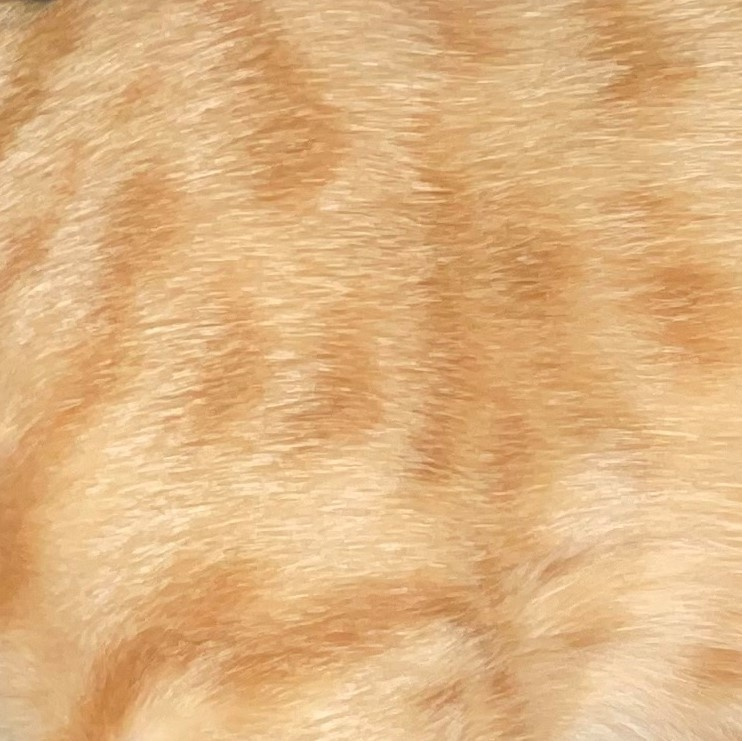

In [7]:
model_name = '/content/cut1.jpg'
style_img = imread(model_name)
imshow(style_img)

# RD system is fully isotropic, so we use a variant of texture loss that
# tries to match input image with rotated versions of the target sample
target_styles = []
for r in np.linspace(0.0, 360, 65)[:-1]+0.12345:
  img = ndimage.rotate(style_img, r, reshape=False, mode='wrap')
  style, _ = style_model.calc_style_content(img[None,...])
  target_styles.append(style)
imwrite('%s.jpg'%model_name, style_img)

In [8]:

ca = CA()
loss_log = []

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 10000], [1e-3, 2e-4, 5e-5])
trainer = tf.optimizers.Adam(lr)

@tf.function
def style_loss_f(x):
  imgs = to_rgb(x)
  gs, content = style_model.calc_style_content(imgs)
  sl = np.inf
  for ts in target_styles:
    sl = tf.minimum(sl, style_loss(gs, ts))
  return tf.reduce_mean(sl)

# *BONUS* Inception-V1 feature visualisztion loss may produce
# interesting patterns for some channels (esp. for those
# that correspond to isotropic textures)
@tf.function
def inception_loss_f(x):
  imgs = to_rgb(x)
  clip_imgs = tf.clip_by_value(imgs, 0.0, 1.0)
  overflow_loss = tf.reduce_mean(tf.square(clip_imgs-imgs))
  tensor = model(clip_imgs)['mixed4a_pre_relu']
  loss = -tf.reduce_mean(tensor[...,461])
  return loss + overflow_loss*10.0

pool = seed_f(1024)

@tf.function
def train_step(x):
  with tf.GradientTape() as g:
    step_n = tf.random.uniform([], 32, 128, tf.int32)
    for i in tf.range(step_n):
      x = ca(x)
    loss = style_loss_f(x)
  params = ca.trainable_variables
  grads = g.gradient(loss, params)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, params))
  return loss, x

  pl.ylim(np.min(loss_log), loss_log[0])



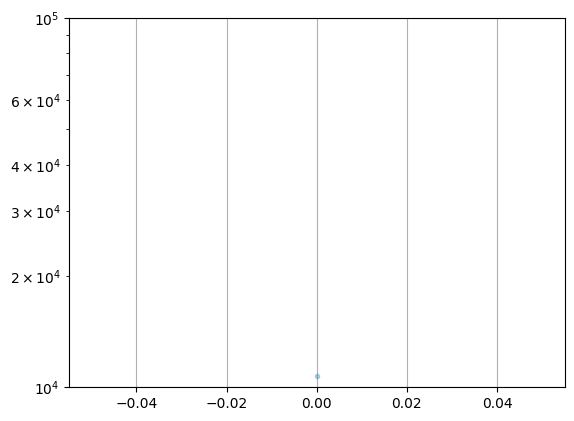

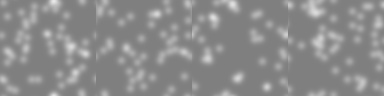

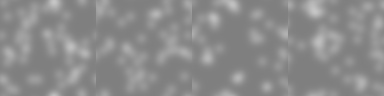

 1 10743.478

In [ ]:

for i in range(20000):
  batch_idx = np.random.choice(len(pool), 4, replace=False)
  x0 = pool[batch_idx]
  if i%32==0:   # periodically inject seed states in the batch
    x0[:1] = seed_f(1)
  h, w = x0.shape[1:-1]
  loss, x = train_step(x0)
  pool[batch_idx] = x
  loss_log.append(loss.numpy())
  if i%16 == 0:
    clear_output(True)
    pl.plot(loss_log, '.', alpha=0.3)
    if np.min(loss_log) > 0.0:
      pl.yscale('log')
    pl.ylim(np.min(loss_log), loss_log[0])
    pl.grid()
    pl.show()
    imshow(np.hstack(to_rgb(x0)))
    imshow(np.hstack(to_rgb(x)))
    print('\r', len(loss_log), loss.numpy(), end='')
  if len(loss_log)%1000 == 0:
    np.save('%s_%05d.npy'%(model_name, len(loss_log)),
            [v.numpy() for v in ca.variables])




In [ ]:
#@title Veido of the result {vertical-output: true}
with VideoWriter() as vid:
  x = seed_f(1, 256)
  for i in tqdm.tnrange(30*8):
    step_n = min(int(2**(i/30.0)), 200)
    for _ in range(step_n):
      x = ca(x, r=0.5)
    frame = to_rgb(x)[0]
    vid.add(zoom(frame, 2))